In [54]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
%matplotlib inline
import matplotlib.pyplot as plt
import sys

In [55]:
df = pd.read_excel("ActualDataFeb2020.xlsx")

In [56]:
#данные для моделирования
cols = list(df.columns[1:])
list(enumerate(cols))

[(0, 'Gpp'),
 (1, 'Tpp'),
 (2, 'Gp4'),
 (3, 'Go4'),
 (4, 'Tp4'),
 (5, 'T04'),
 (6, 'Gp5'),
 (7, 'Go5'),
 (8, 'Tp5'),
 (9, 'To5'),
 (10, 'Gp2'),
 (11, 'Go2'),
 (12, 'Tp2'),
 (13, 'To2'),
 (14, 'Gpp2'),
 (15, 'Gpb4'),
 (16, 'Gpp7'),
 (17, 'To7'),
 (18, 'Tp11'),
 (19, 'To11'),
 (20, 'Go11'),
 (21, 'Gp14'),
 (22, 'Go14'),
 (23, 'To14'),
 (24, 'GpSN4'),
 (25, 'GoSN4'),
 (26, 'TpSN4'),
 (27, 'ToSn4'),
 (28, 'GpSN5'),
 (29, 'GoSN5'),
 (30, 'TpSN5'),
 (31, 'ToSN5'),
 (32, 'GoSN2'),
 (33, 'ToSN2')]

In [57]:
input_data = df[cols].values
input_data = input_data.astype("float32")

### Уравнения для моделирования
$
\begin{equation*}
Gp2\;=\;Go2+GoSN2\\Go11\;=\;Go4\;+\;GoSN4\;-\;Go2\\To11\;=\;(Go4\ast To4\;+\;GoSN4\ast ToSN4\;-\;Go2\ast To2)/Go11\\Gpb4\;=\;Gp2\;+\;Go11\\Gp4\;=\;Gpb4\;-\;GpSN4\\Go14\;=\;Gpp\;+\;Go5\;+\;GoSN5\\To14\;=\;(Gpp\ast Tpp\;+\;Go5\ast To5\;+\;GoSN5\ast ToSN5)/Go14\\Gp5\;=\;Go14\;-\;GpSN5\\\\\\
\end{equation*}
$
### Примитивный транслятор линейных уравнений в матрицу 

In [58]:


#Матрица переменных уравнения
equations=  [["Gp2", "Go2", "GoSN2"], 
            ["Go11", "Go4", "GoSN4", "Go2"], 
            ["Gpb4", "Gp2", "Go11"], 
            ["Gp4", "Gpb4", "GpSN4"],
            ["Go14", "Gpp", "Go5", "GoSN5"],
            ["Gp5", "Go14", "GpSN5"]]
#Матрица переменных уравнения уравнения в виде a+b+c=0, но выражаться будет именно а
koef = [[-1,1,1], \
        [-1,1,1,-1], \
        [-1,1,1], \
        [-1,1,-1], \
        [-1,1,1,1], \
        [-1,1,-1]] 

In [59]:
def set_linear_matrix(list_equations,all_columns,koef):
    size = len(all_columns)
    result = np.eye(size,dtype="int")
    for i,equation in enumerate(list_equations):
        axis0_index = all_columns.index(equation[0])
        for j,right_value in enumerate(equation[1:]):
            #зануляем изначальную заглушку уравнения
            result[axis0_index][axis0_index] = 0
            #записываем уравнение
            axis1_index = all_columns.index(right_value)
            result[axis0_index][axis1_index] = koef[i][j+1]/((-1)*koef[i][0])
    return result

In [60]:
#Собираем матрицу коэффициентов уравнений
transition_matrices = set_linear_matrix(equations,cols,koef)

In [61]:
#Посмотрим на одно уравнение для Gp2 в данном случае
transition_matrices[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [62]:
input_data[:2]

array([[ 309.94,  107.65, 1922.  , 2042.  ,  109.35,   63.53, 1172.  ,
         779.  ,  112.04,   63.86,  955.04,  846.48,  103.95,   64.47,
         111.  , 2288.07,  276.  ,   66.07,   97.04,   66.06, 1259.  ,
        1172.  , 1465.1 ,   80.48,  276.85,  151.91,   99.15,   83.48,
         219.48,  293.34,  111.62,   88.  ,   66.78,   82.  ],
       [ 315.52,  107.42, 1920.  , 2042.  ,  109.47,   63.55, 1172.  ,
         777.  ,  111.99,   63.89,  951.14,  831.38,  104.13,   64.55,
         138.  , 2273.9 ,  276.  ,   66.08,   97.07,   66.1 , 1264.  ,
        1173.  , 1467.8 ,   80.49,  276.7 ,  151.86,   99.17,   83.49,
         219.41,  292.78,  111.64,   88.  ,   47.67,   82.  ]],
      dtype=float32)

In [63]:
# Инициализируем фильтр Калмана
kf = KalmanFilter(transition_matrices = transition_matrices,
                  observation_matrices = np.eye(len(cols)))

In [64]:
# Используем ЕМ для подбора параметров. Иначе фильтр лишь частично улучшит предсказания
kf = kf.em(input_data,10)

In [65]:
filtered_data, _ = kf.filter(input_data)

In [66]:
#Для увеличения окна вывода
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 82em; }</style>"))

/home/danil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/home/danil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/home/danil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the r

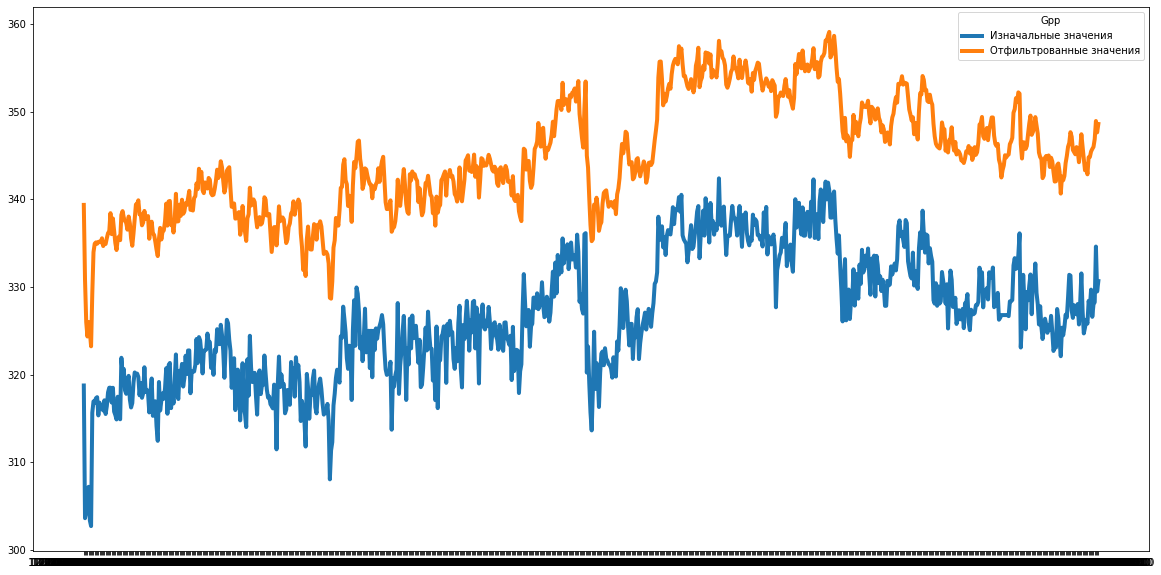

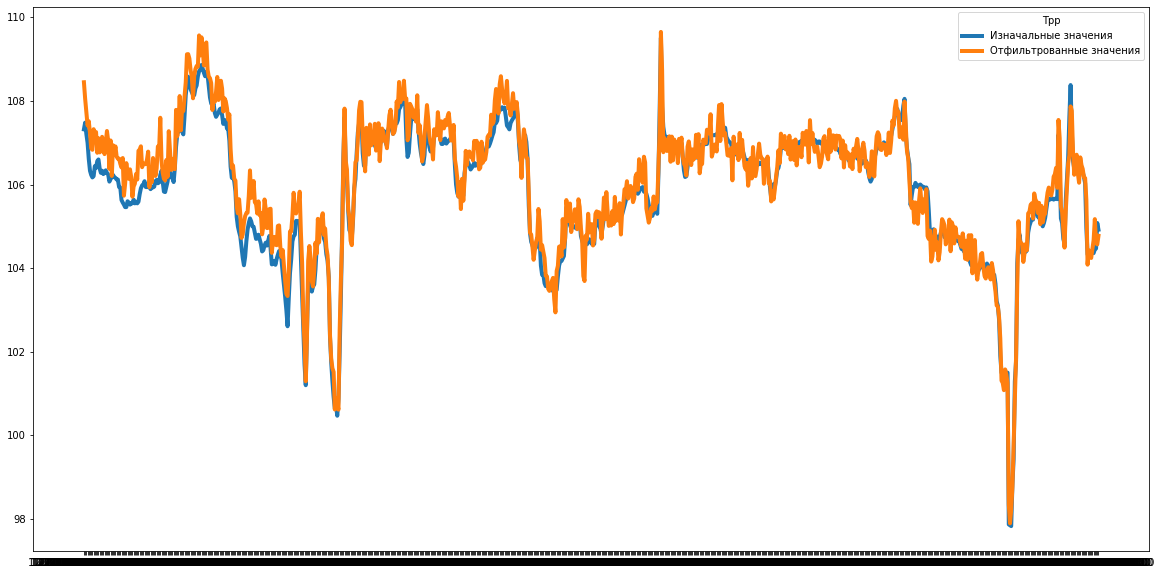

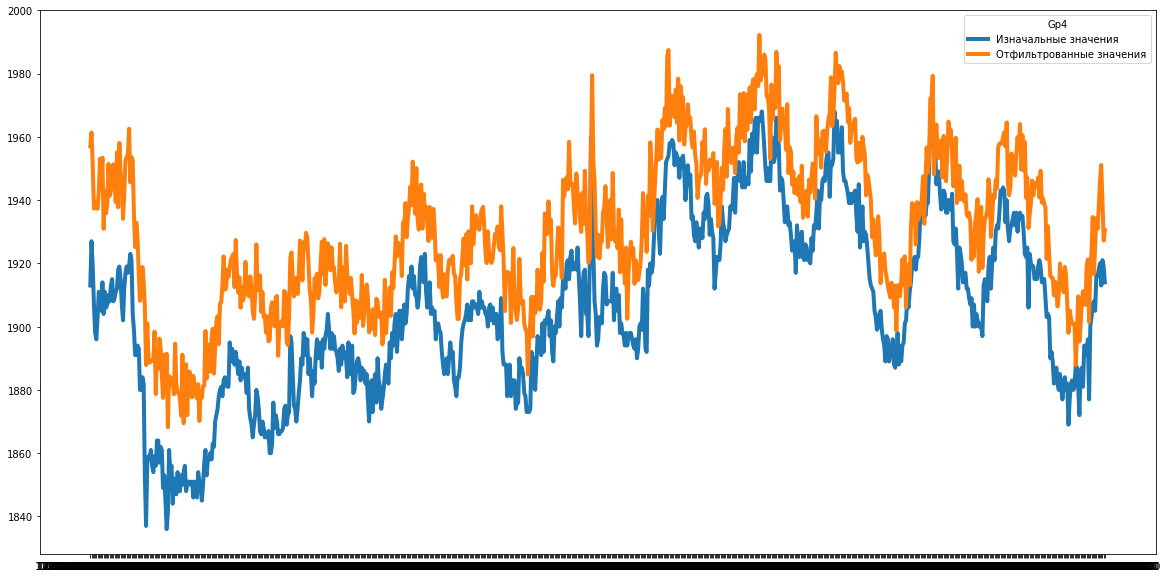

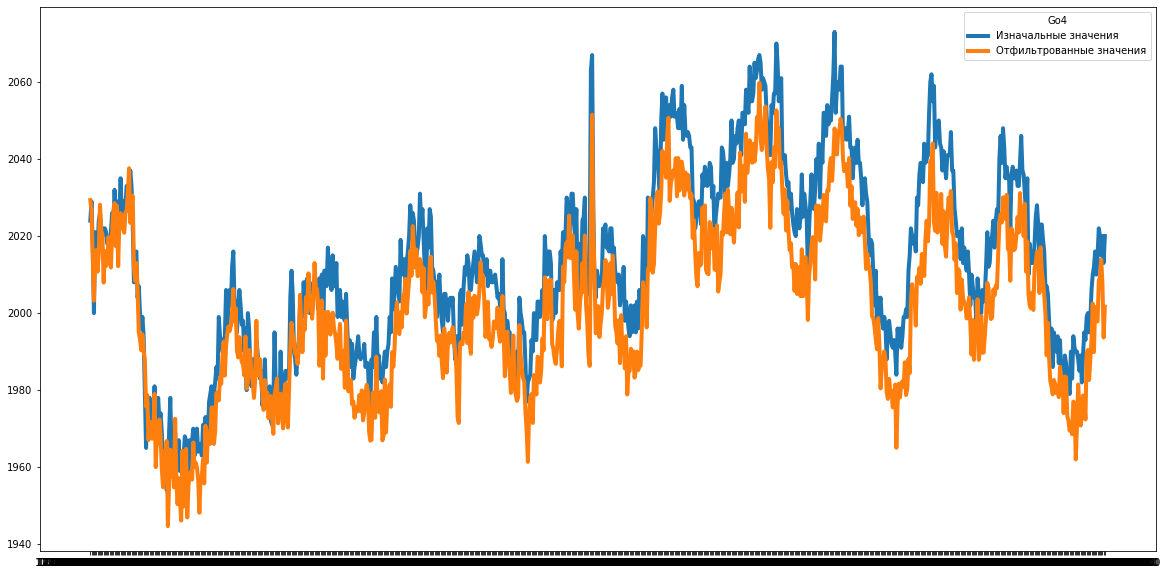

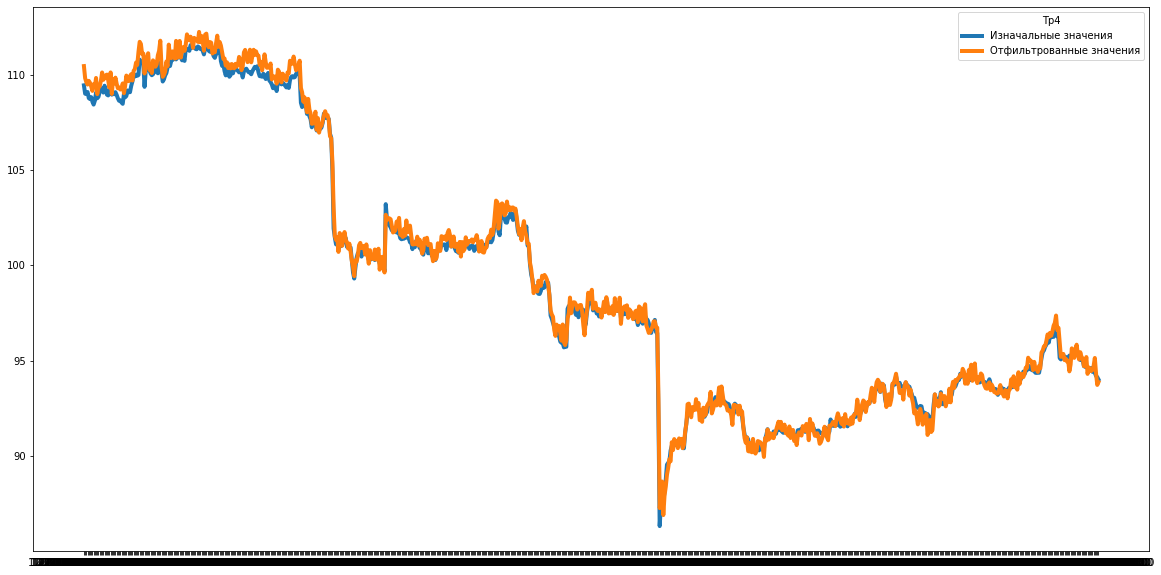

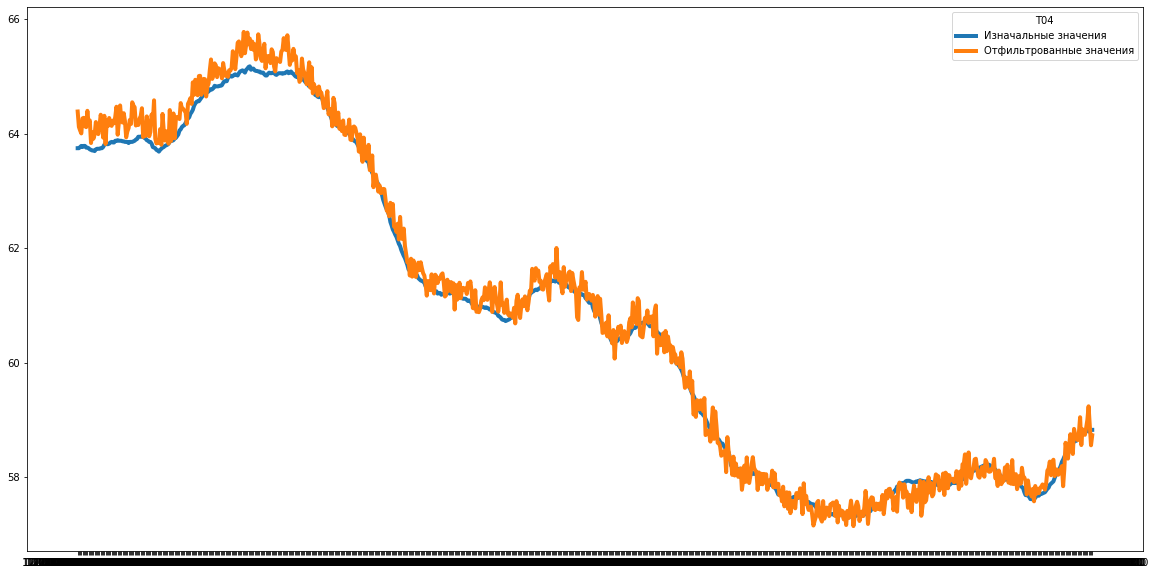

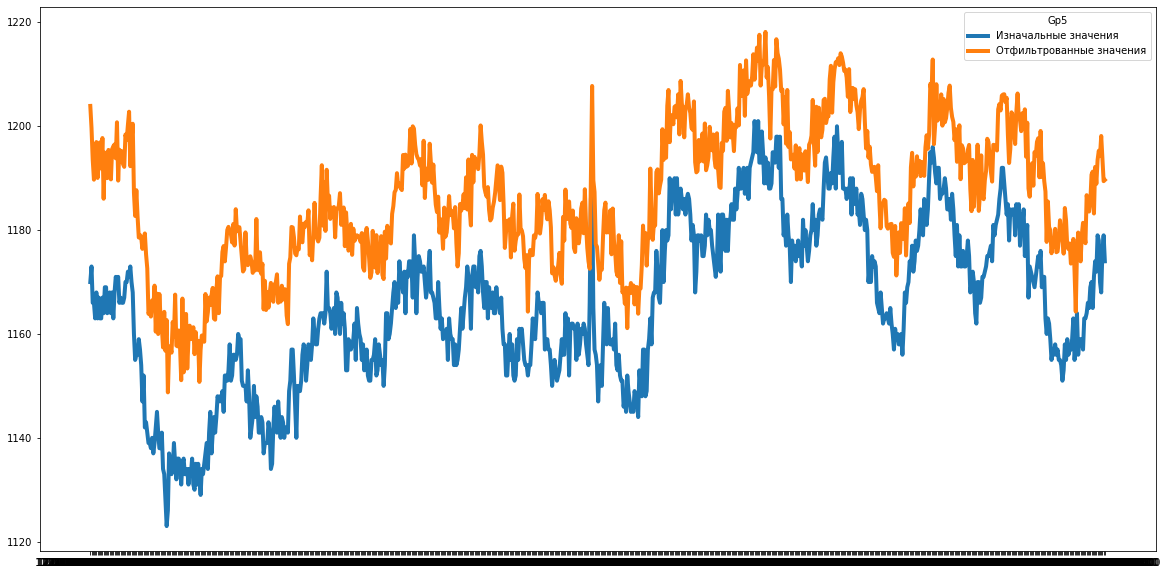

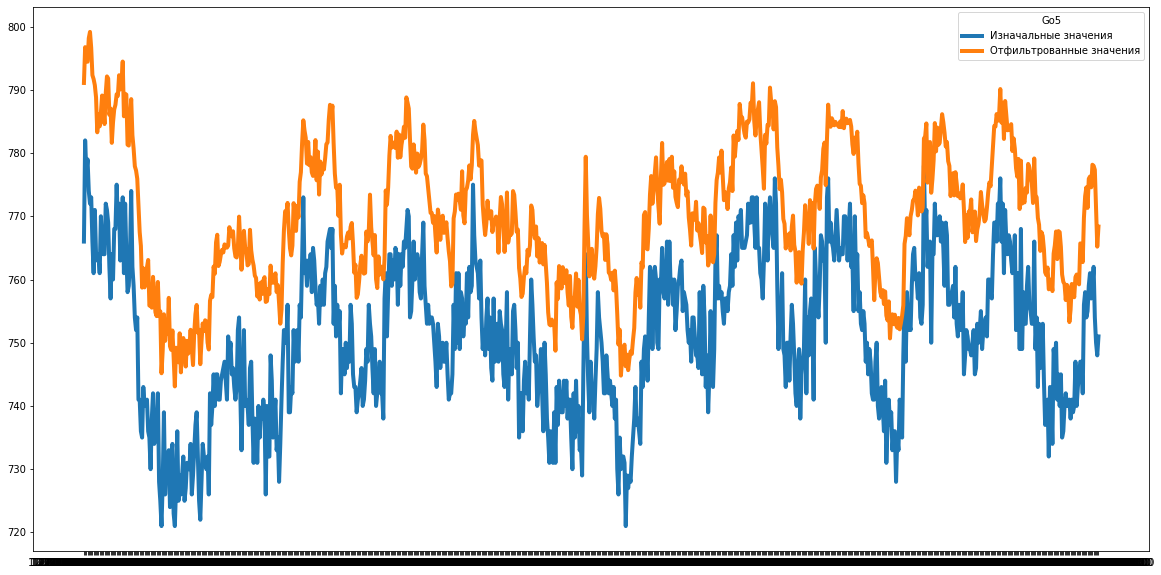

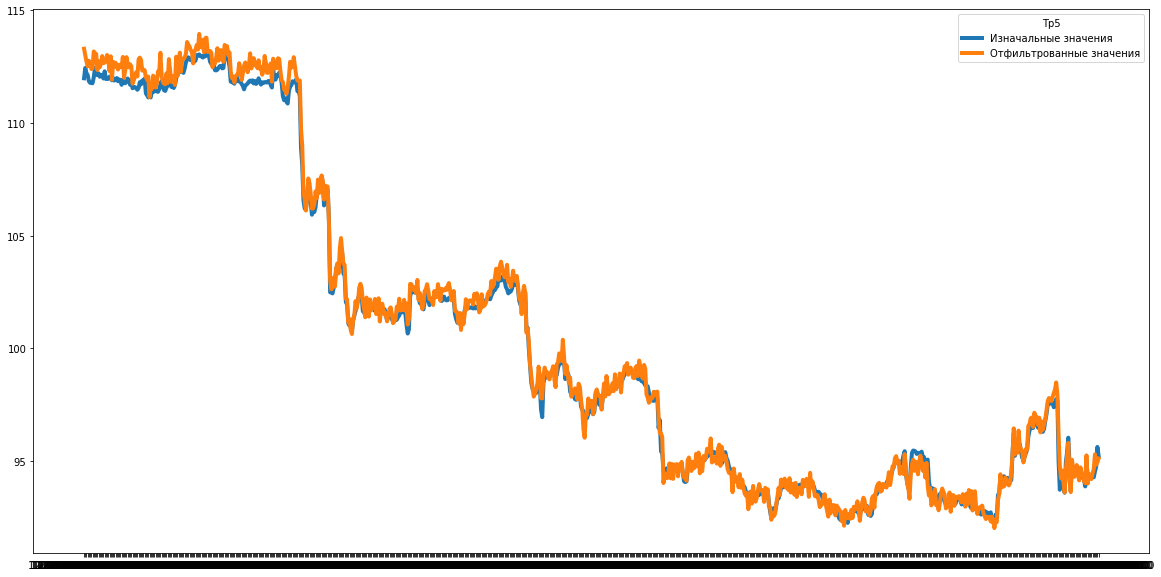

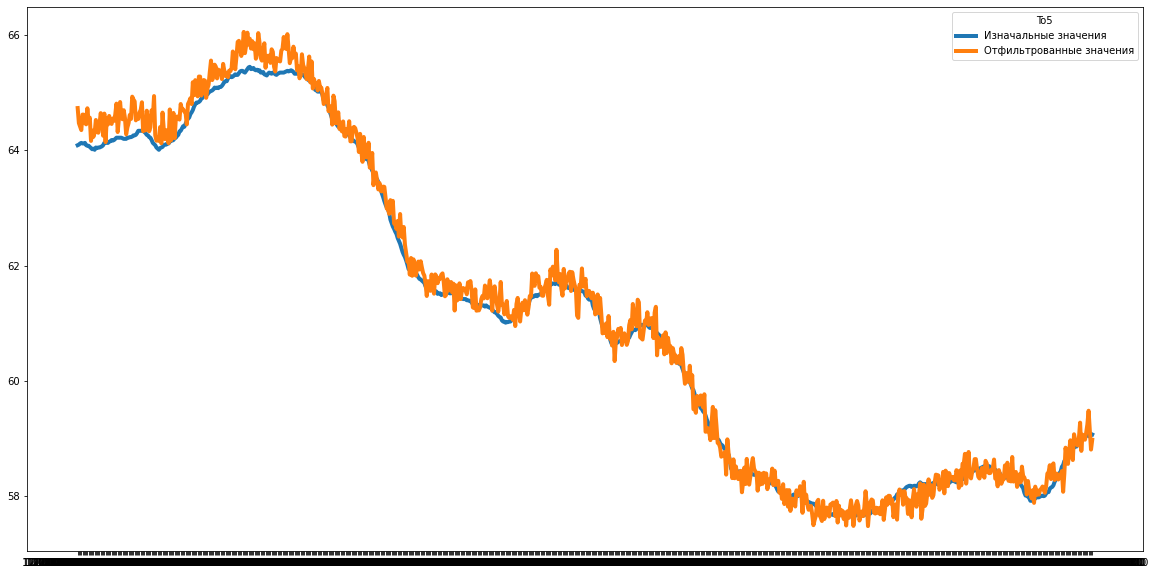

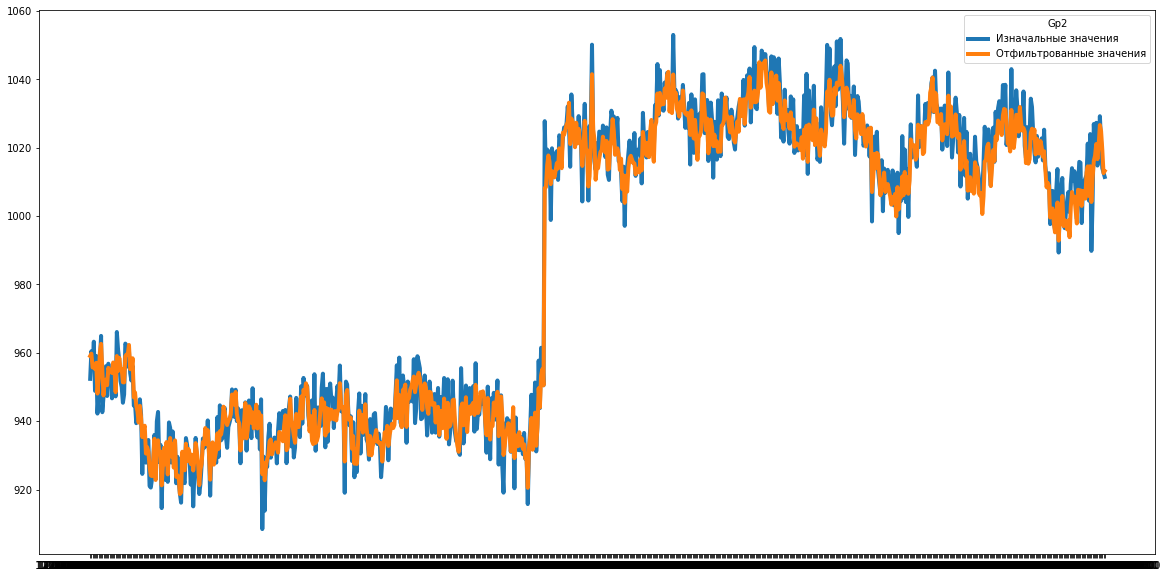

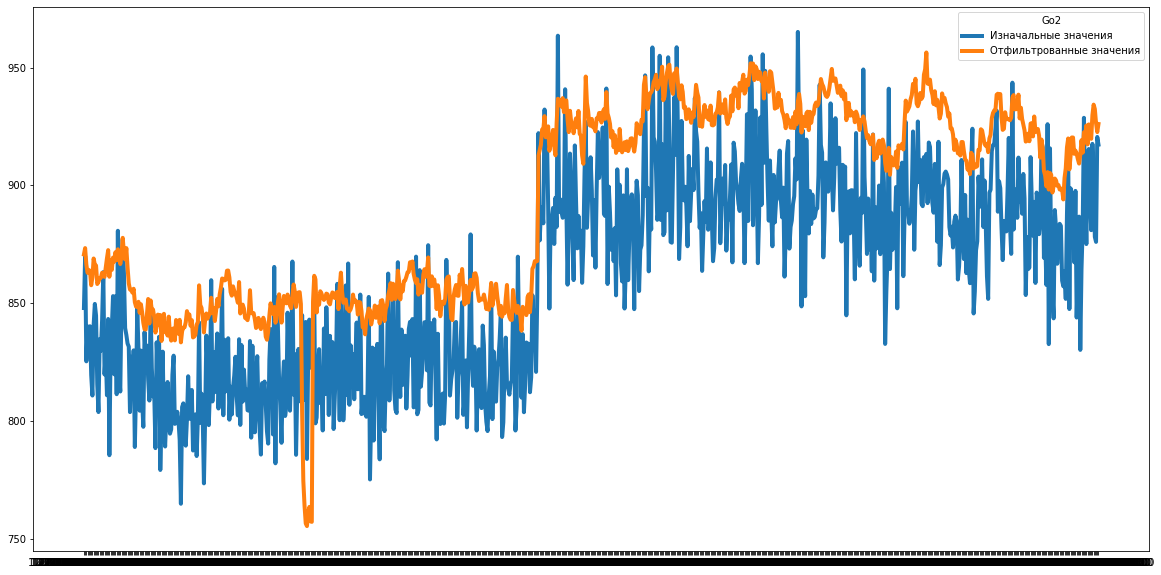

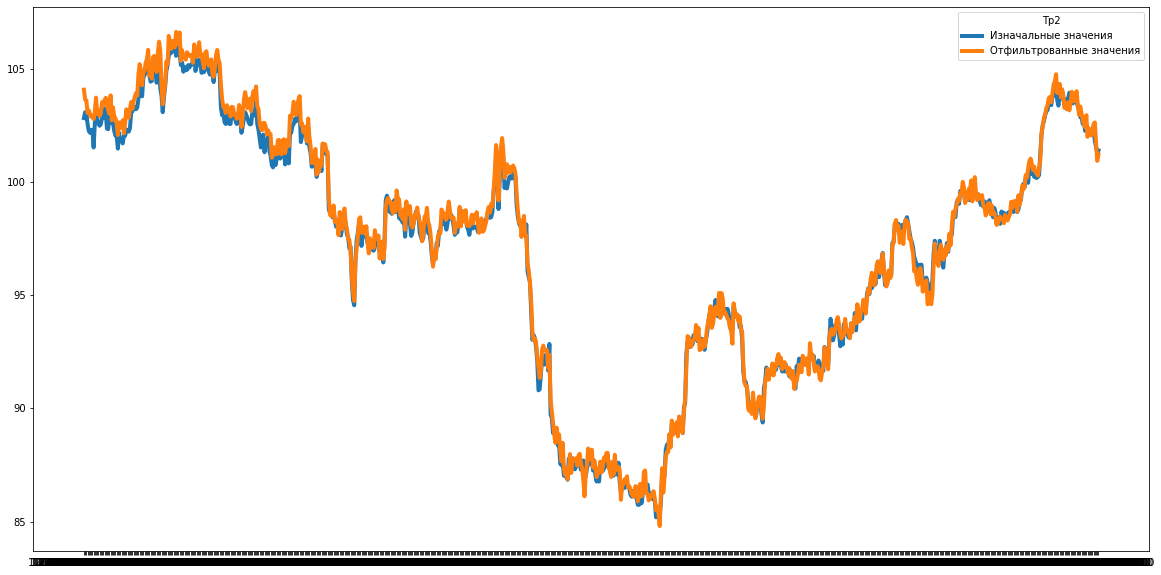

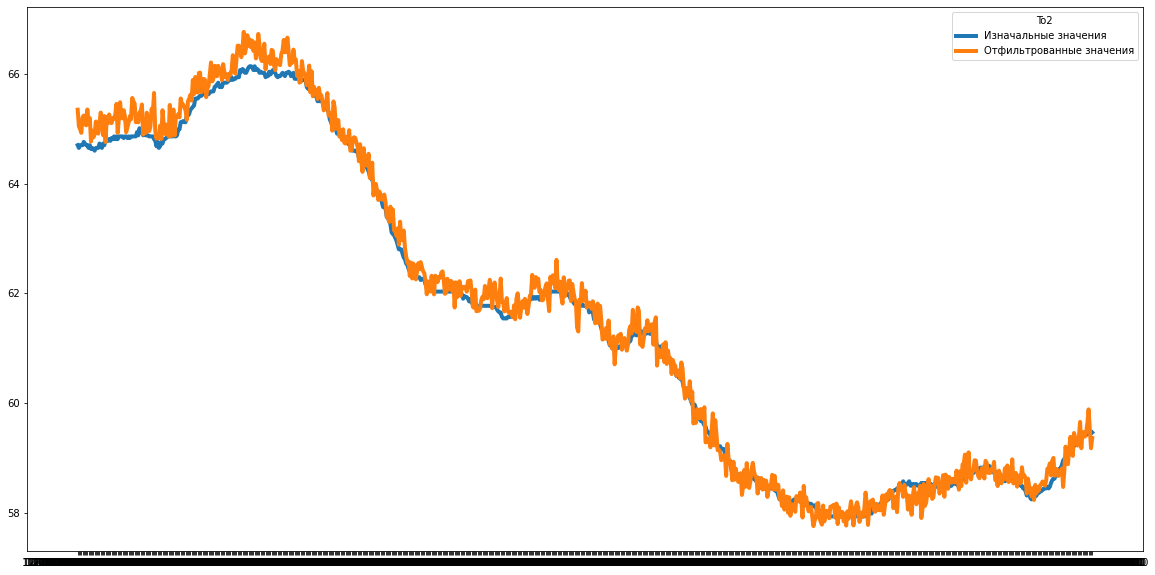

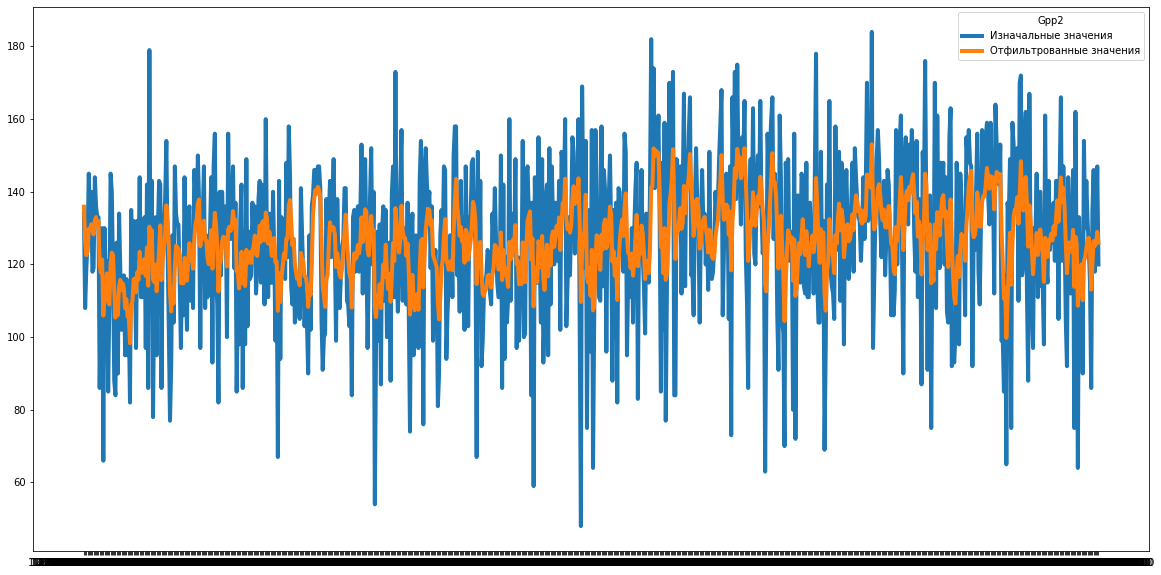

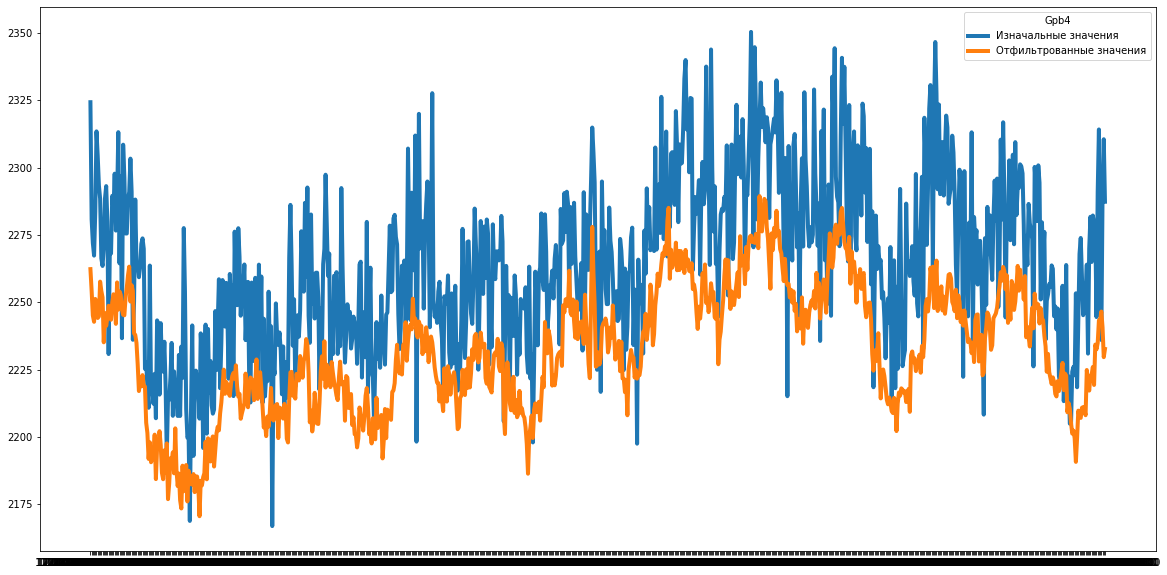

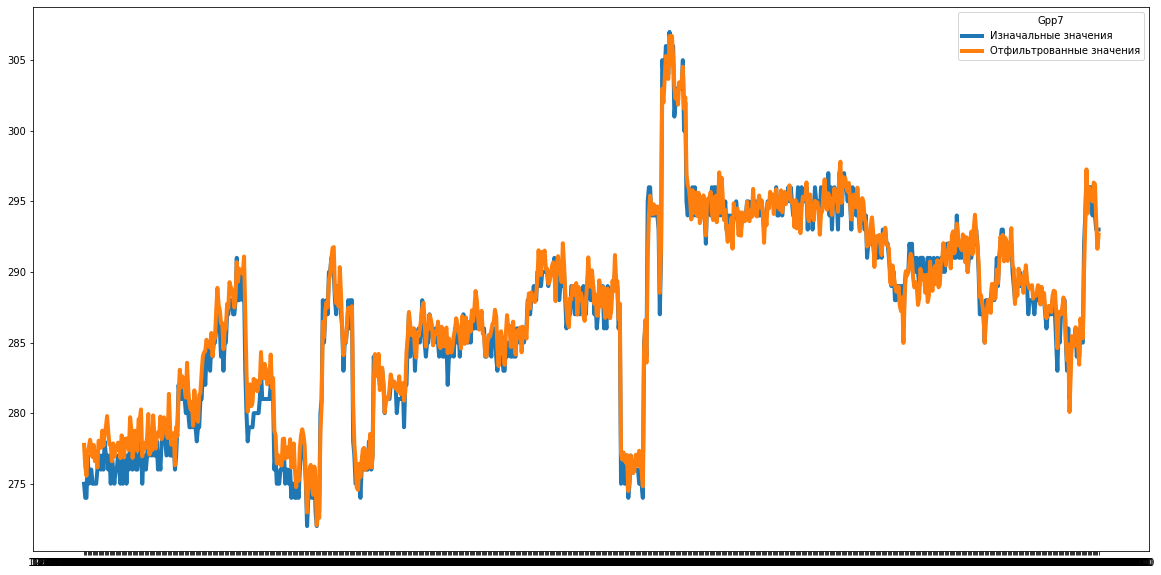

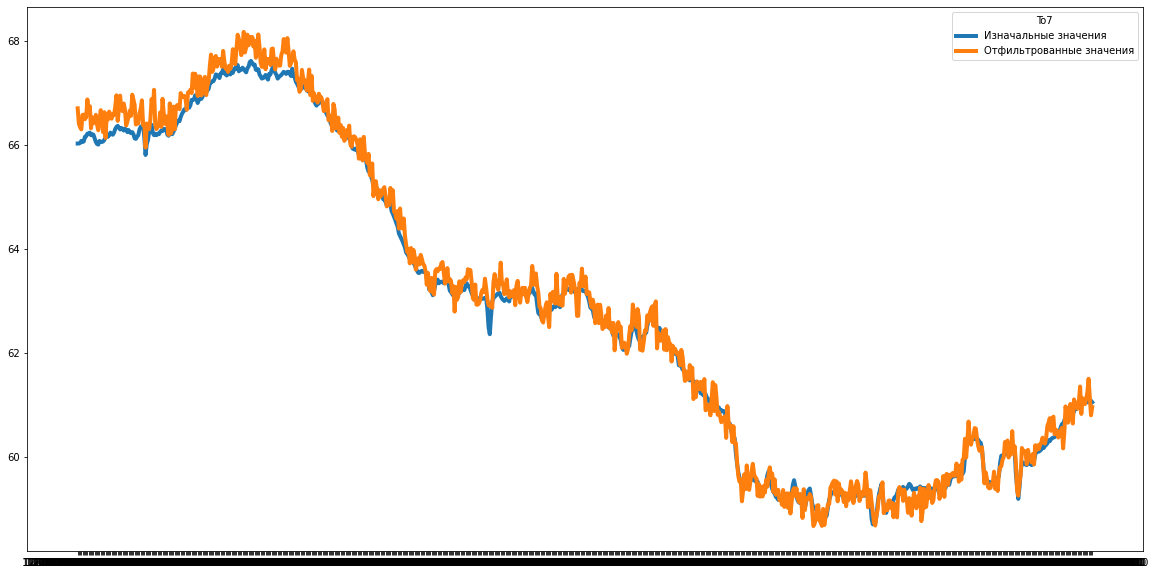

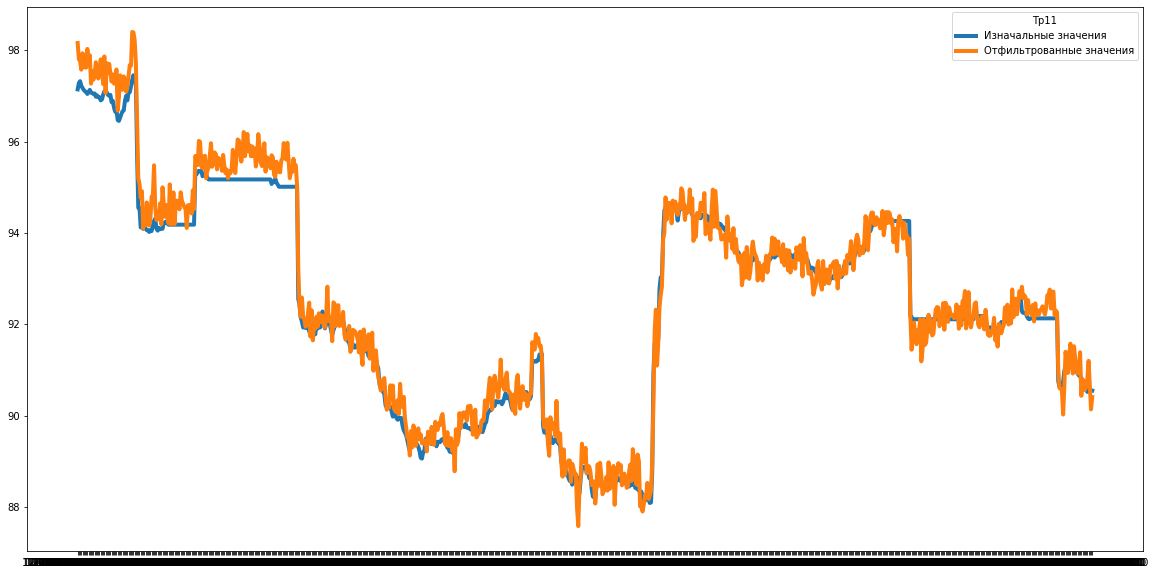

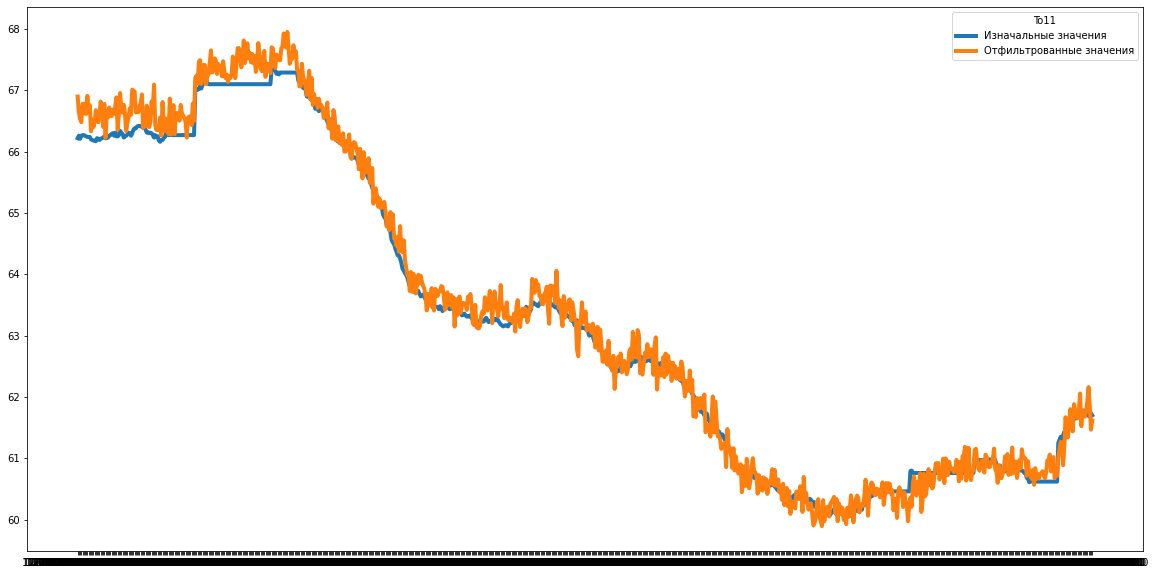

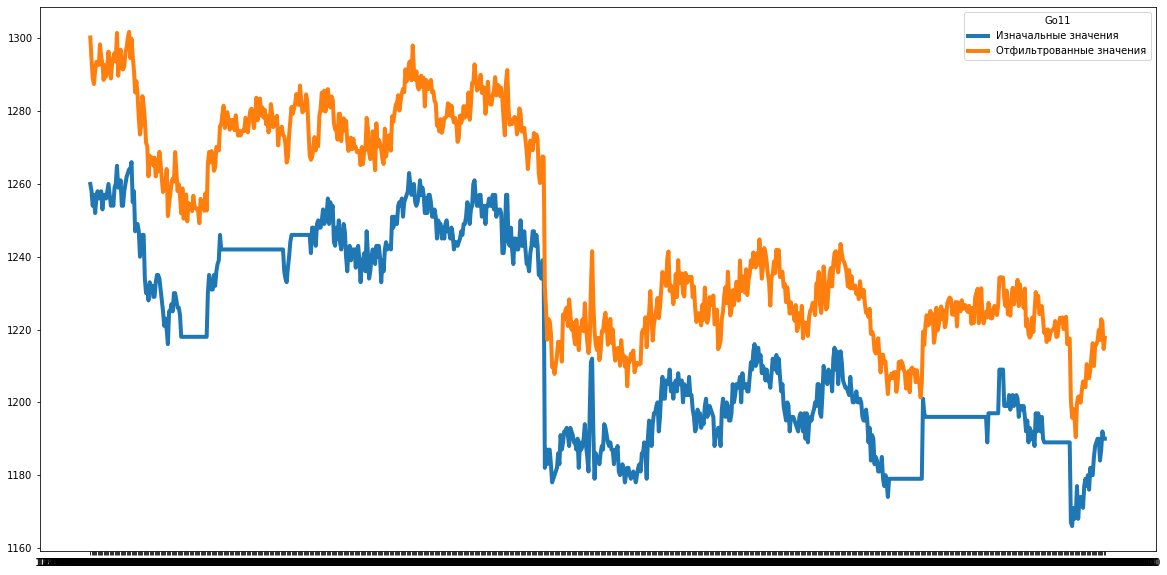

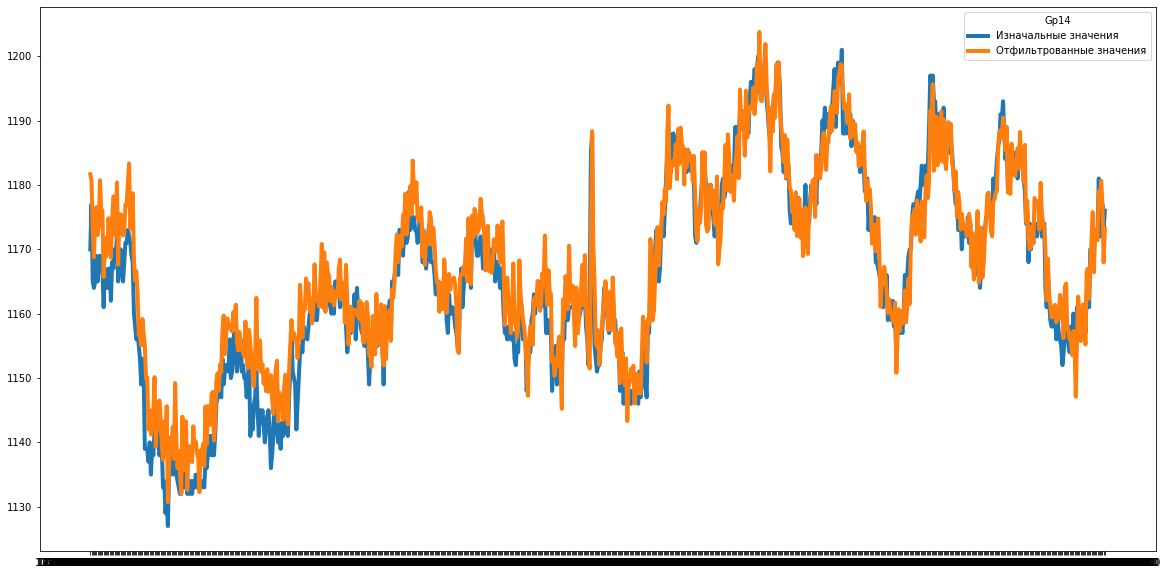

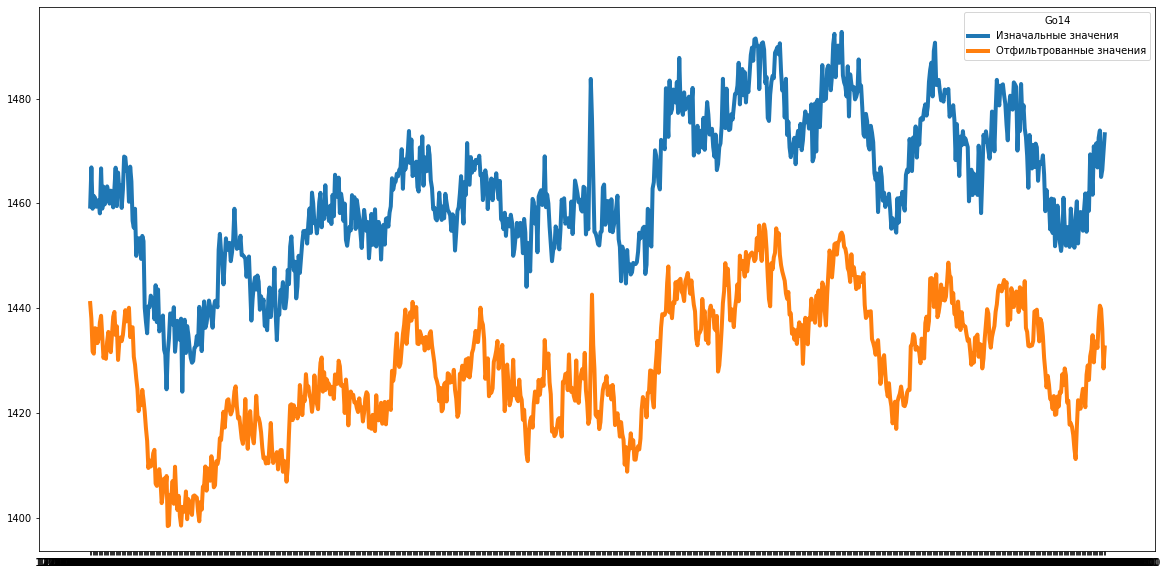

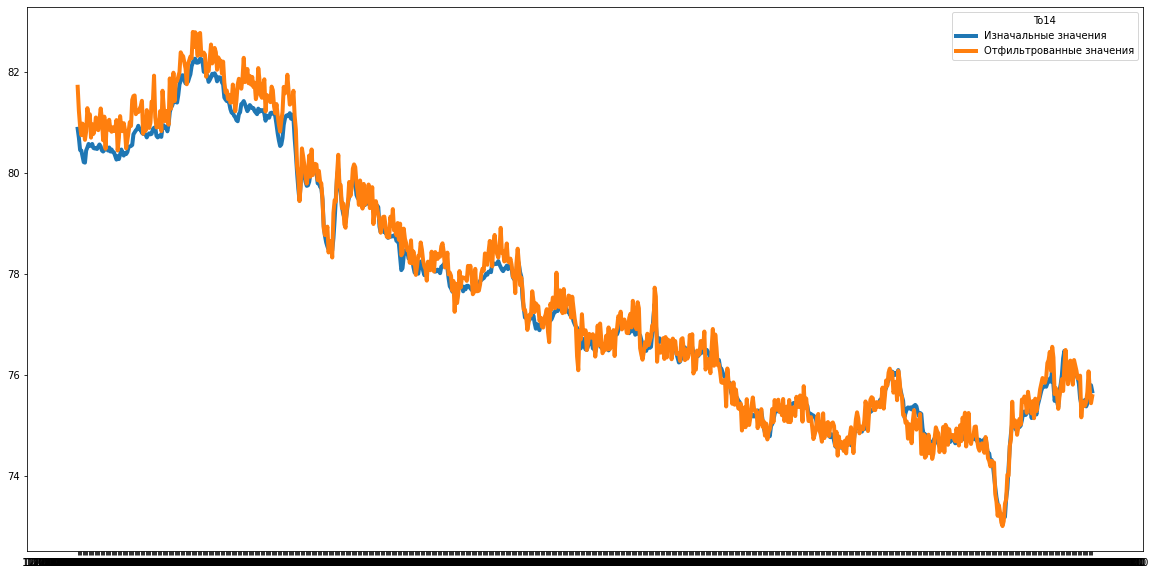

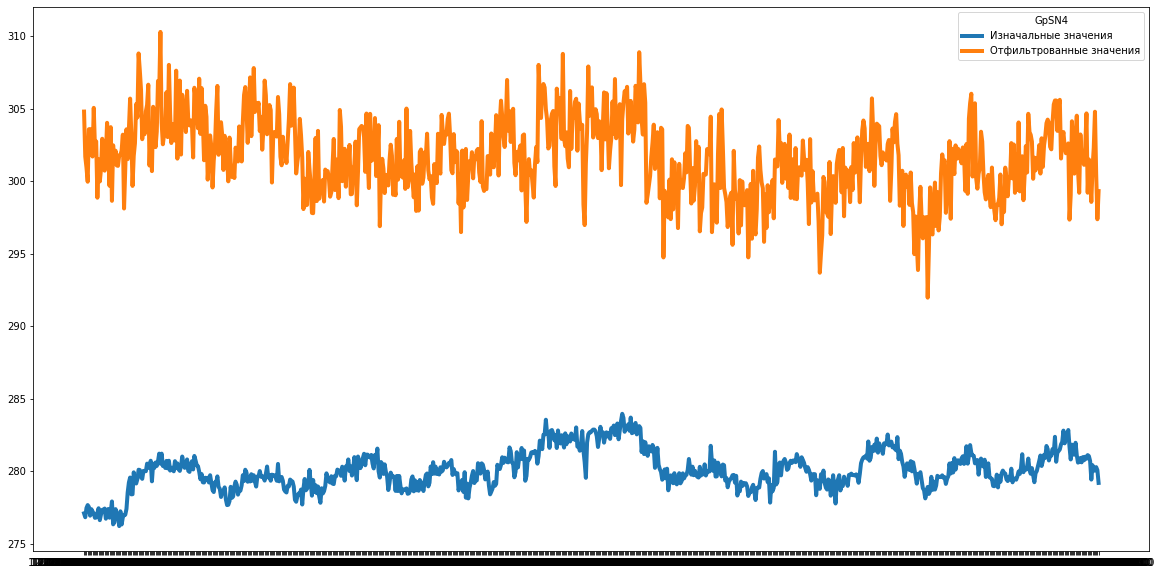

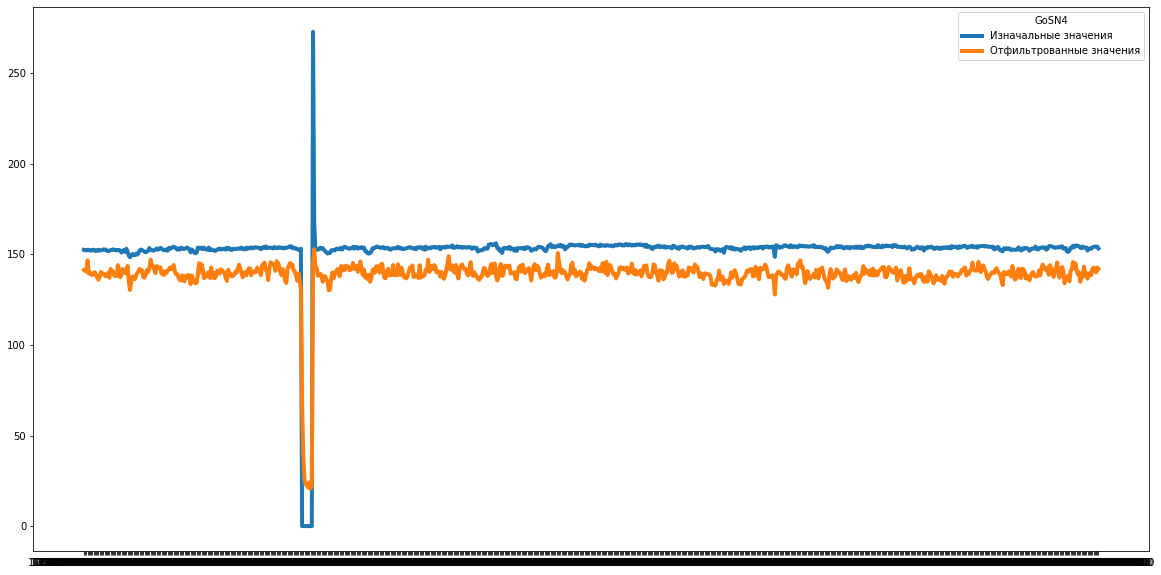

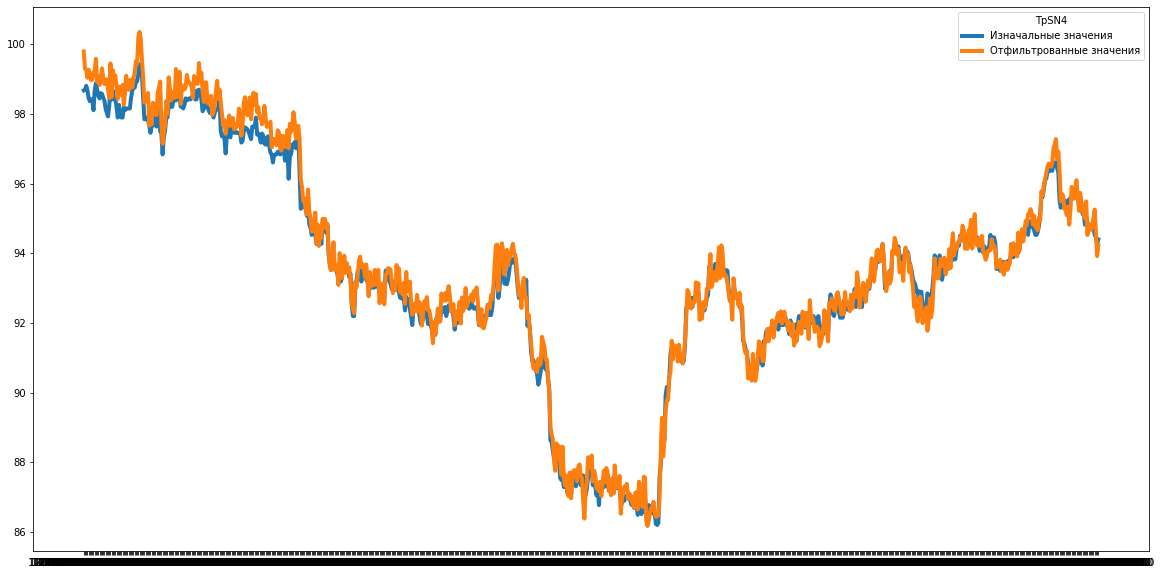

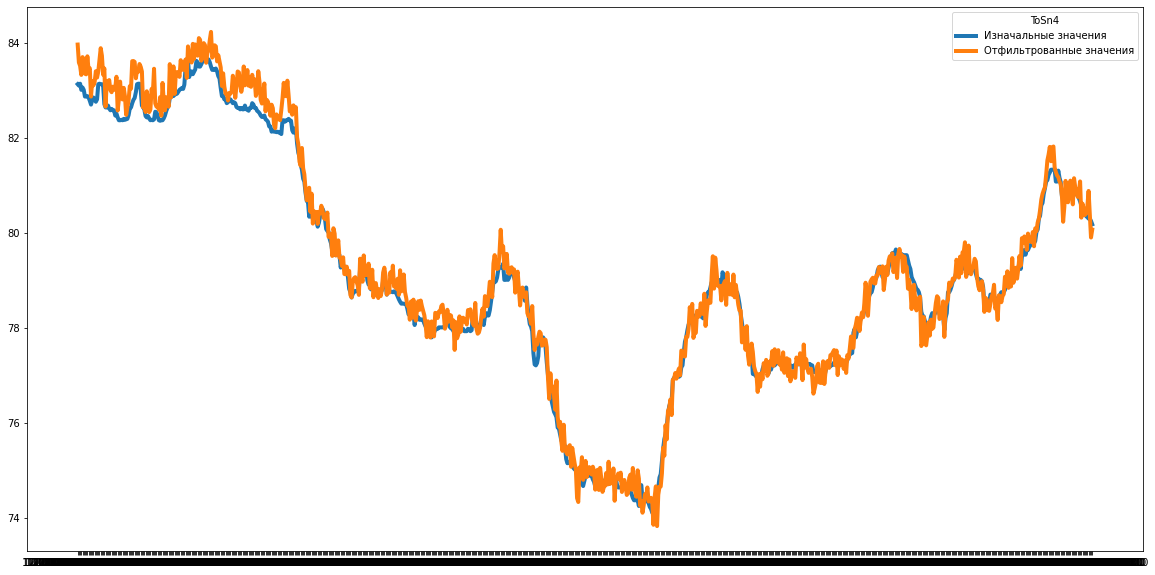

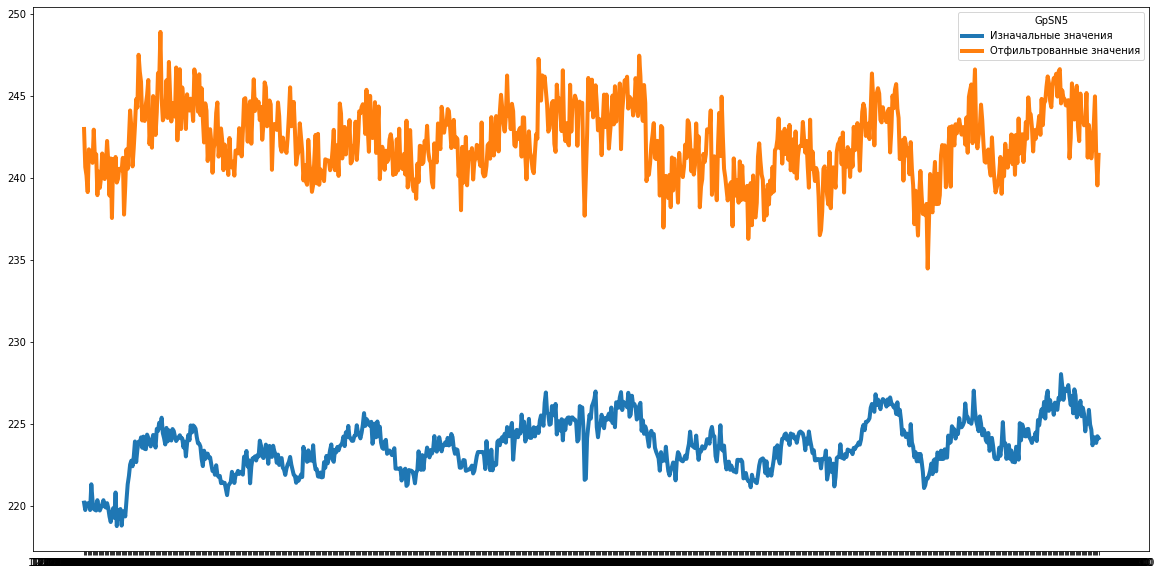

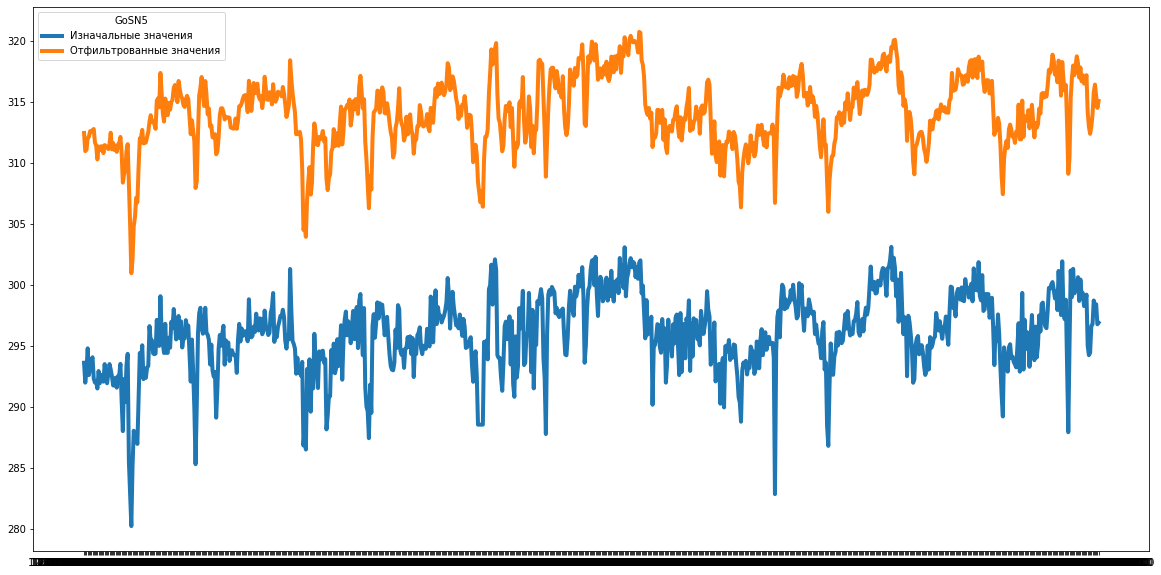

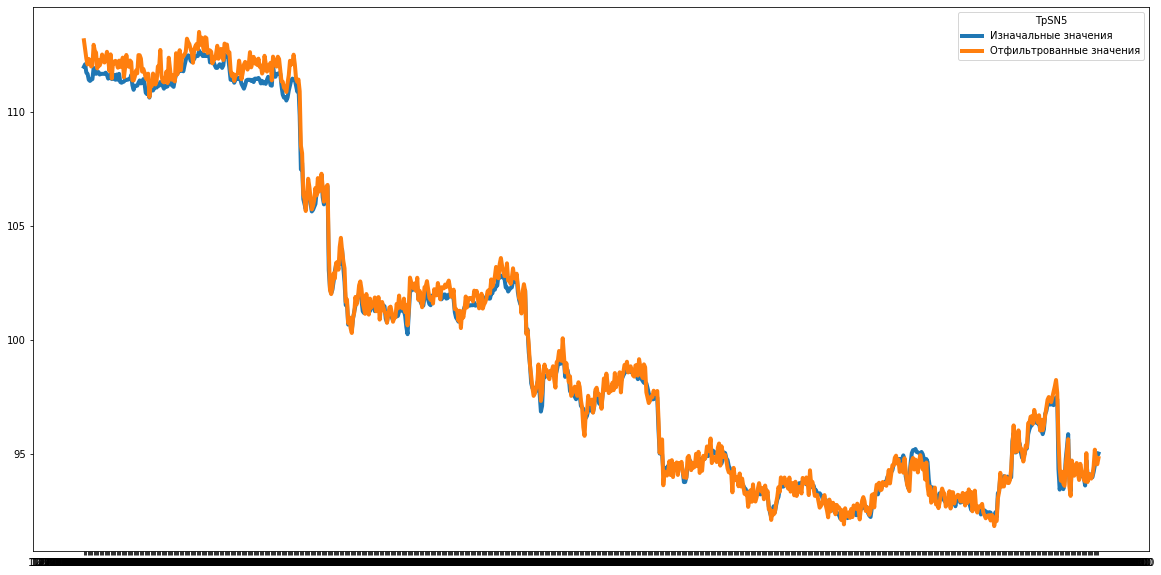

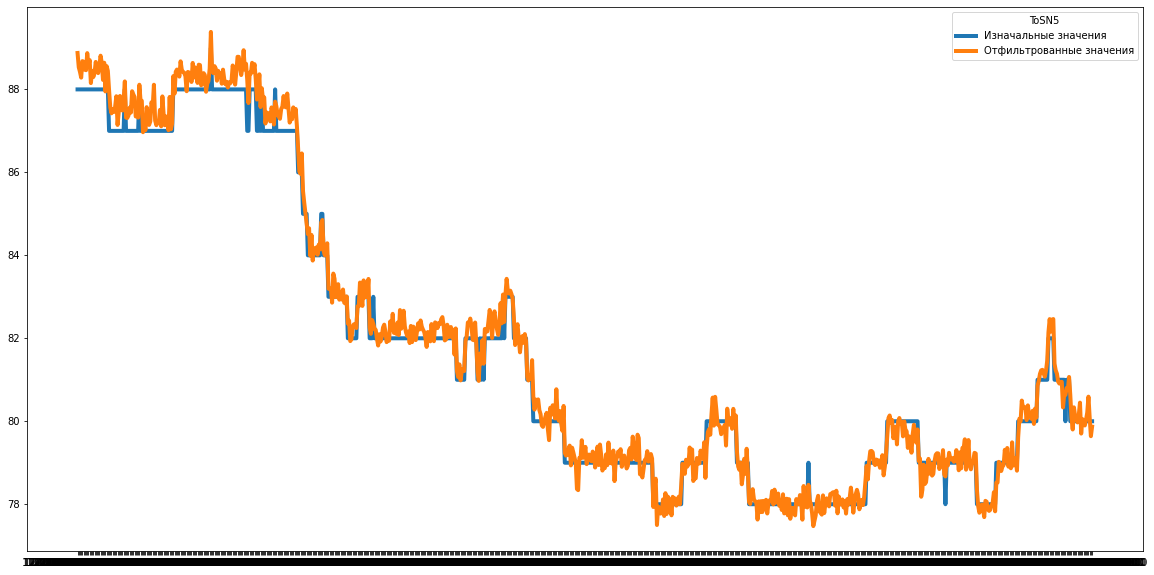

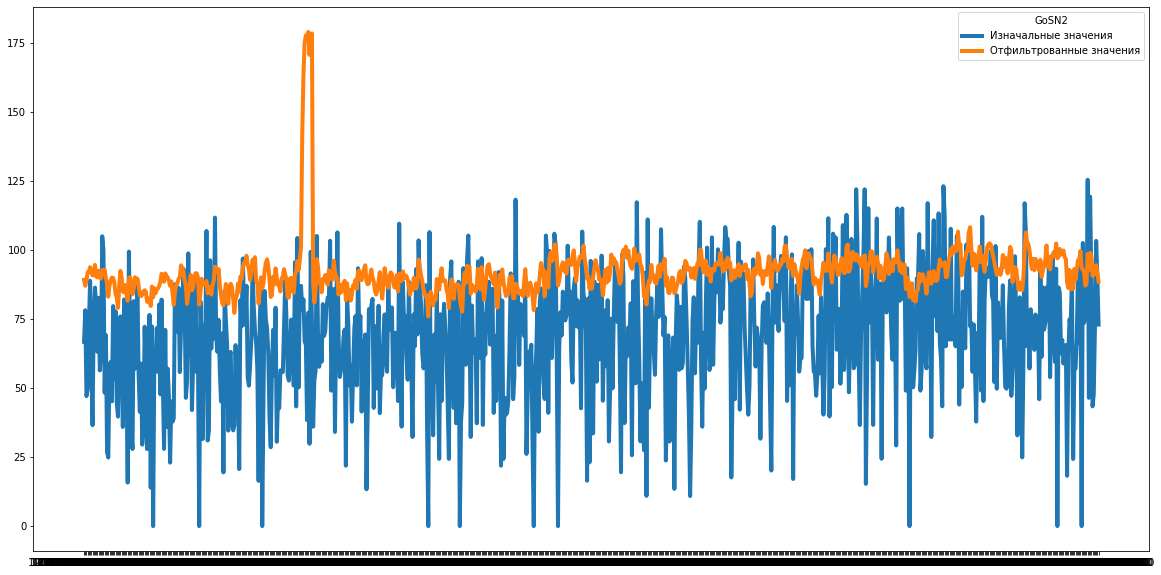

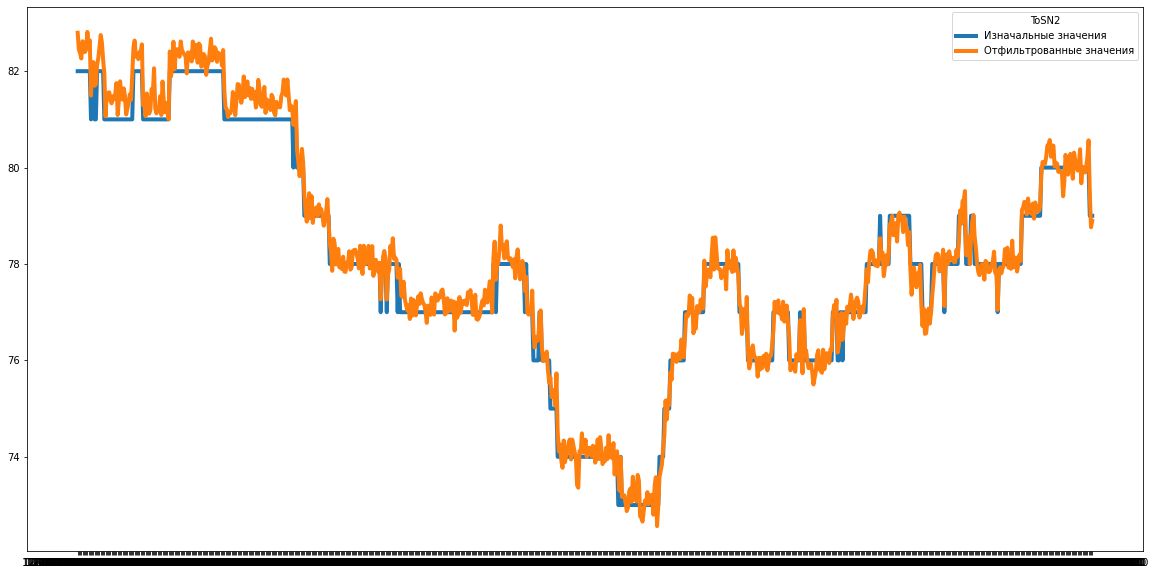

In [67]:
time = df['Дата - Время']


for col_num,col_name in enumerate(cols):
    fig,axes=plt.subplots(1,1)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    axes.plot(time[10:],input_data[10:,col_num],lw=4, label = 'Изначальные значения')
    axes.plot(time[10:],filtered_data[10:,col_num],lw=4, label = 'Отфильтрованные значения')
    axes.legend(title=col_name)


### Посчитаем невязки уравнений

In [68]:
def error_of_equation(data,equation,all_columns,koef):
    result=np.zeros(data.shape[0])
    for time in range(len(data)):
        err_now = 0
        for j,value in enumerate(equation):
            axis1_index = all_columns.index(value)
            err_now+=koef[j]*data[time][axis1_index]
        result[time] = (-1) * err_now
    return result

In [69]:
equations[0]
#При этом считается невязка y(t) = Gp2 - Go2 - GoSN2

['Gp2', 'Go2', 'GoSN2']

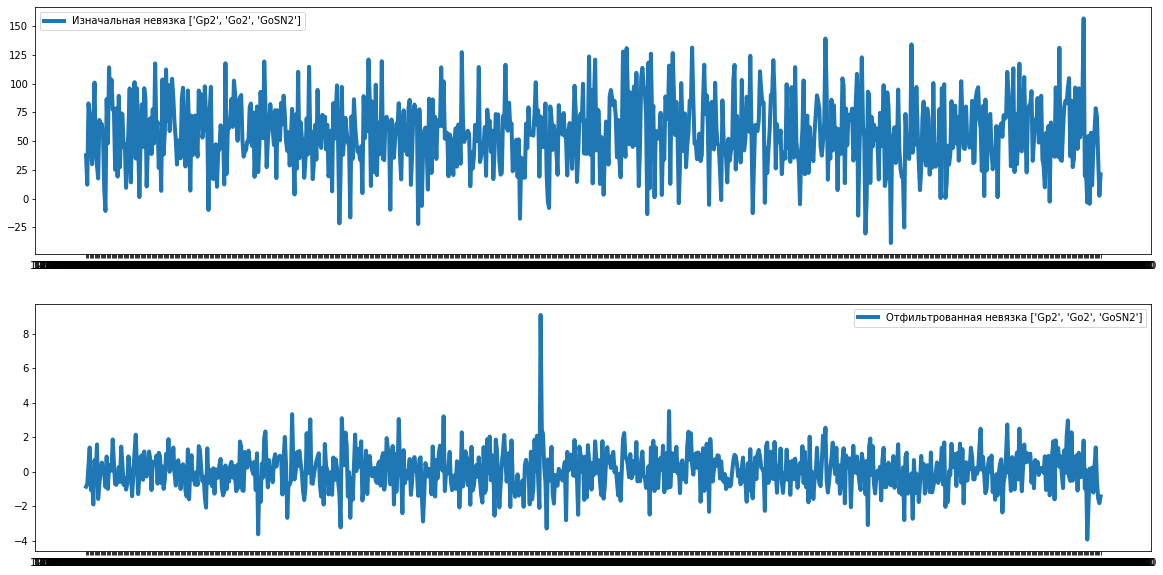

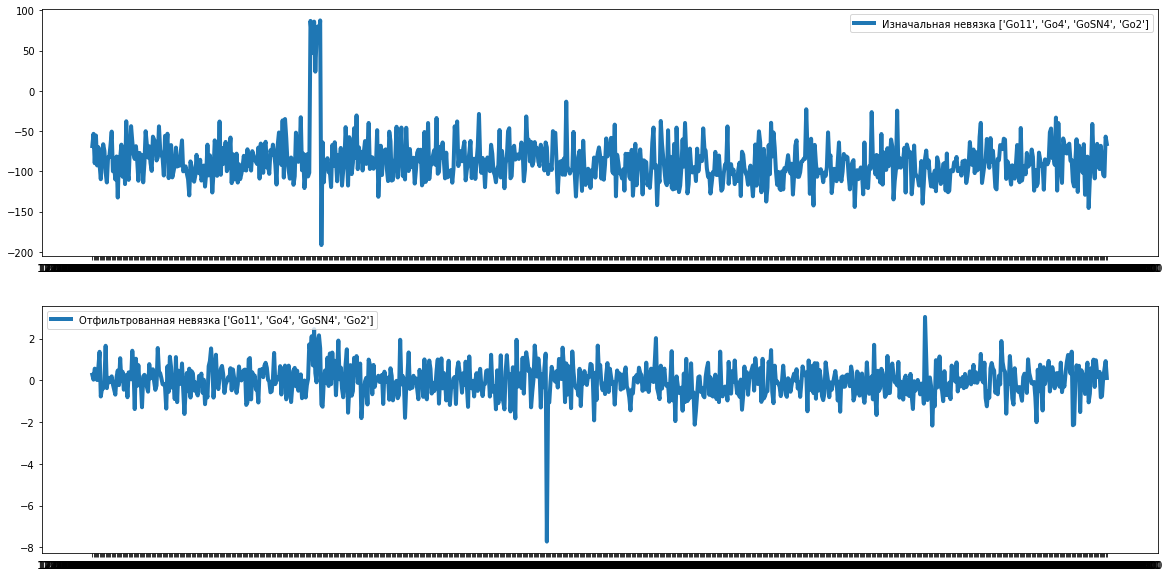

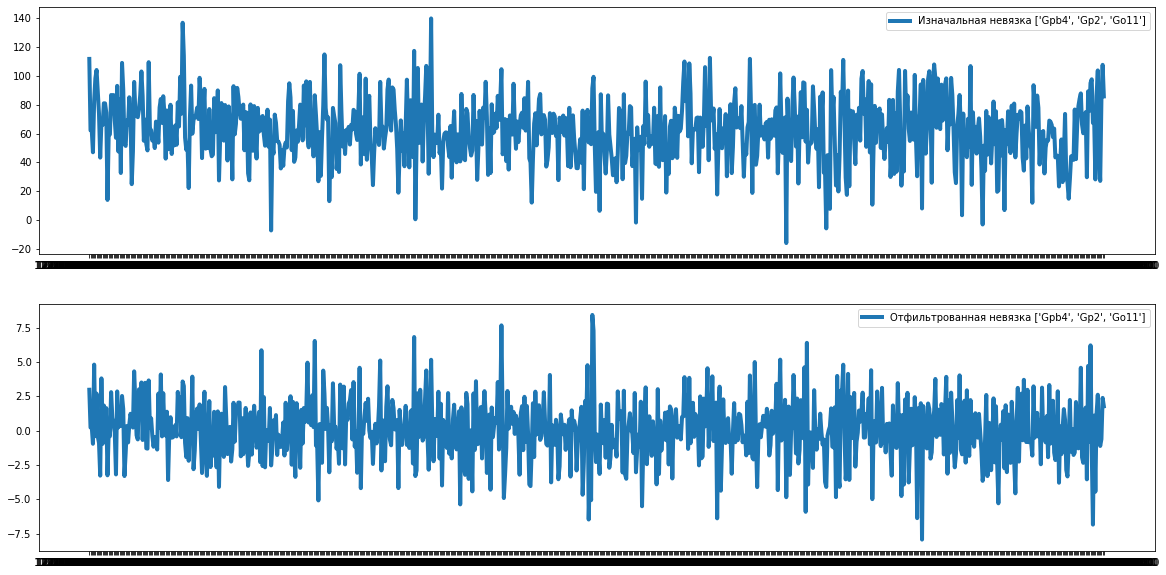

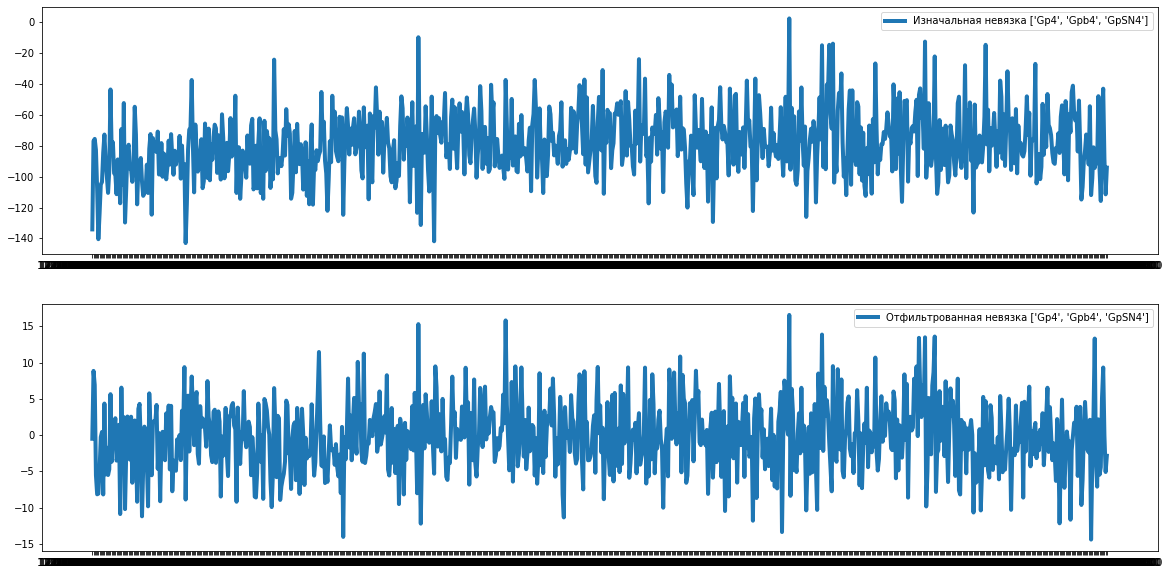

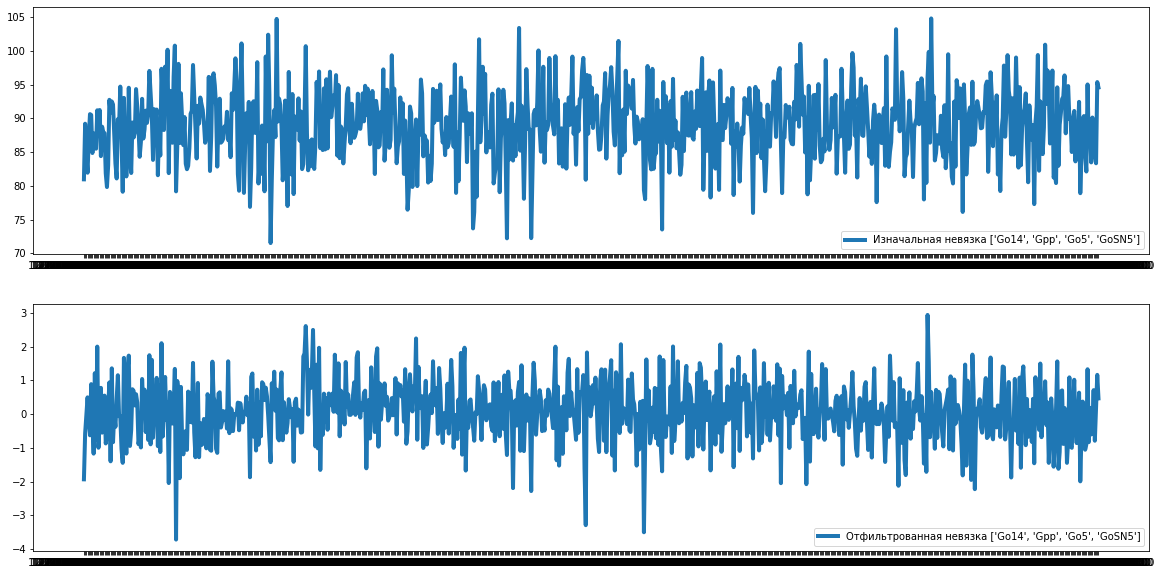

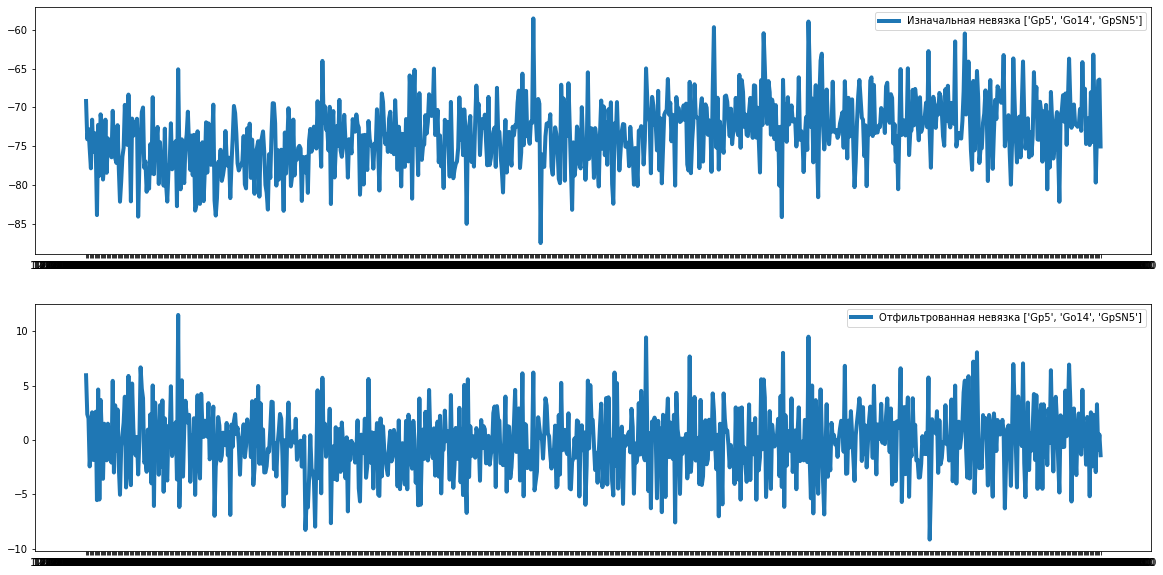

In [70]:
for eq_num,eq_name in enumerate(equations):
    err_input_data = error_of_equation(input_data,eq_name,cols,koef[eq_num])
    err_filtered_data = error_of_equation(filtered_data,eq_name,cols,koef[eq_num])
    
    fig,axes=plt.subplots(2,1)
    fig.set_figheight(10)
    fig.set_figwidth(20)

    axes[0].plot(time[10:],err_input_data[10:],lw=4, label = 'Изначальная невязка ' +str(eq_name))
    axes[1].plot(time[10:],err_filtered_data[10:],lw=4, label = 'Отфильтрованная невязка '+str(eq_name))

    axes[0].legend()
    axes[1].legend()

<font size="3">Как видно, происходит аномалия в вычислениях в некоторых местах. Но там же аномалия наблюдается и в исходных данных. Так что в таком случае имеет смысл очищать входные данные от аномалий и направлять соответствующее предупреждение <br><br> По поводу того, что мы используем статическую систему: алгоритм подстраивается под изменения, так что смена режимов ему не страшна, что видно из полученных графиков (Мы считаем что система зависит от предыдущих измерений, так что просадка 1-2 измерения на перестройку коэффициентов) <br><br> Момент с тем, что, вообще говоря, параметры на станции меняются непрерывно, здесь учтен плохо, ибо если один параметр увеличится резко, а другие нет, то алгоритм уменьшит изменение этого параметра, а другие немного увеличит, например. Равновесие достигнется через 1-2 шага, но это не совсем корректно, конечно. Подобная проблема с резкими скачками.<br>С плавными она достаточно хорошо сглаживается </font>